In [1]:
import os
import sys
import time
import configparser
%matplotlib inline
%load_ext autoreload
%autoreload 2

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

config = configparser.ConfigParser()
config.read('config_user.ini')

#TO BE CONFIGURED FROM CONFIG FILE
os.environ['ICTDIR'] = config['Paths']['ICTDIR']
os.environ["PATH"] = os.environ["PATH"] + config['Paths']['PATH_APPEND']
# Define the folder base path these are to run in local
base_path = config['Paths']['BASE_PATH']
path_to_wf = config['Paths']['PATH_TO_WF']

print(os.environ["PATH"])

/Users/jjgomezcadenas/Software/geant4-11.2.2-build/bin:/Users/jjgomezcadenas/miniconda3/envs/IC-3.8-2024-06-08/bin:/Users/jjgomezcadenas/miniconda3/condabin:/Users/jjgomezcadenas/.juliaup/bin:/Users/jjgomezcadenas/.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/Users/jjgomezcadenas/.local/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/jjgomezcadenas/.local/bin:/Users/jjgomezcadenas/NEXT/IC/bin


In [2]:
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from dataclasses import dataclass
from dataclasses import astuple

In [3]:
from peak_functions import find_peak_params, rebin_sum, rebin_2d, s12_energy, print_peak_pars, apply_threshold, PeakPars
from peak_functions import get_s2_windows, s2_windows_sum, sipm_xg, get_sipm_max

In [4]:
from aux_functions import check_folder_exists, get_filename_event, read_waveforms
from aux_functions import make_temp_file, launch_reco_irene, read_irene
from ic_functions import deconvolve, suppress_glow, find_dead_pmts, corrected_sum_without_dead_pmts 
from ic_functions import active_pmts, sgn_sipms
from plot_functions import plot_sum_waveform, plot_waveform, plot_sipmw  
from plot_functions import plot_waveform_zoom_peak, plot_waveform_zoom_peaks, plot_signal_sipms 
from plot_functions import plot_waveform_right_peak, plot_waveform_right_peaks
from plot_functions import plot_waveform_pmts, plot_pmt_max_rms, histo_q_sigma,  histo_q
from plot_functions import plot_sipm_max_rms
from plot_functions import plot_sum_PMT, plot_single_PMT, plot_sipm
from plot_functions import plot_peaks 
import irene_params as ip
from irene_params import fkr_globs, fkr_pars, fkr_pars_run_1463, masked_sipm
from irene_params import get_units, get_s1_tmin_tmax, get_s2_tmin_tmax, get_maw, get_thr_sipmw, get_var_with_units

In [5]:
from invisible_cities.cities.components import deconv_pmt, get_number_of_active_pmts
from invisible_cities.cities.components import calibrate_pmts, zero_suppress_wfs, calibrate_sipms 
from invisible_cities.cities.components import compute_and_write_pmaps,collect,wf_from_files
from invisible_cities.database.load_db import DataSiPM
from invisible_cities.database.load_db import DataPMT

In [6]:
from invisible_cities.database import load_db 

In [7]:
from invisible_cities.core   import tbl_functions        as tbl

In [8]:
from invisible_cities.dataflow import  dataflow as  fl
from invisible_cities.dataflow.dataflow import pipe, push, sink, fork, count

In [9]:
from invisible_cities.reco import peak_functions as pkf

In [10]:
from invisible_cities.types.ic_types  import  minmax
from invisible_cities.types.symbols   import WfType
from invisible_cities.core.system_of_units import adc, pes, mus, ns

# IRENE

## Standard parameters

In [11]:
fkr_pars

{'glow_peak_prominence': 1000,
 'glow_peak_distance': 20,
 's2_peak_prominence': 100,
 's2_peak_distance': 20,
 's1_peak_prominence': 10,
 's1_peak_distance': 10,
 's1_rebin_stride': 4,
 's2_rebin_stride': 80,
 's1_tmin_mus': 0,
 's1_tmax_mus': 1450,
 's2_tmin_mus': 1450,
 's2_tmax_mus': 2000,
 'thr_sipm_s2_pes': 2.0}

## Global parameters

In [12]:
fkr_globs

{'detector_db': 'next100',
 'compression': 'ZLIB4',
 'pmt_samp_wid_mus': 0.025,
 'tbin_pmt_ns': 25,
 'n_maw_samples': 100,
 'thr_maw_adcs': 10,
 'thr_sipm_calib_pes': 1.0,
 'thr_sipm_pes': 5.0}

## Parameters run 1463

In [13]:
fkr_pars_run_1463

{'glow_peak_prominence': 1000,
 'glow_peak_distance': 20,
 's2_peak_prominence': 100,
 's2_peak_distance': 10,
 's1_peak_prominence': 5,
 's1_peak_distance': 10,
 's1_rebin_stride': 4,
 's2_rebin_stride': 80,
 's1_tmin_mus': 0,
 's1_tmax_mus': 250,
 's2_tmin_mus': 0,
 's2_tmax_mus': 800,
 'thr_sipm_s2_pes': 5.0}

## Masked SiPMs

In [14]:
masked_sipm

[2425]

In [15]:
tspmt = fkr_globs["pmt_samp_wid_mus"]
tbin = fkr_globs['tbin_pmt_ns']
print(f"time sample pmt, tbin  = {tspmt} mus, {tbin} samples")

time sample pmt, tbin  = 0.025 mus, 25 samples


## Input

#### run number

In [16]:
run_number = 14643

In [17]:
if run_number == 14643:
    parameters = fkr_pars_run_1463
else:
    parameters = fkr_pars


In [18]:
st1 = get_s2_tmin_tmax(parameters, tbin)
st2 = get_s2_tmin_tmax(parameters, tbin)
s1tmx, s1tmn, is1tmx, is1tmn = astuple(st1)
print(f"s1tmx = {s1tmx/mus} mus, s1tmn = {s1tmn/mus} mus")
print(f"is1tmx = {is1tmx} mus, s1tmn = {is1tmn} mus")

s2tmx, s2tmn, is2tmx, is2tmn = astuple(st2)
print(f"s2tmx = {s2tmx/mus} mus, s2tmn = {s2tmn/mus} mus")
print(f"is2tmx = {is2tmx}, is2tmn = {is2tmn}")

s1tmx = 800.0 mus, s1tmn = 0.0 mus
is1tmx = 32000 mus, s1tmn = 0 mus
s2tmx = 800.0 mus, s2tmn = 0.0 mus
is2tmx = 32000, is2tmn = 0


### adc to pes conversion

In [19]:
DataPMTX    = load_db.DataPMT("next100", run_number = run_number)
adc_to_pes = np.abs(DataPMTX.adc_to_pes.values)
adc_to_pes = adc_to_pes[adc_to_pes > 0]
adc_to_pes[(adc_to_pes > 1e+3)] = 0

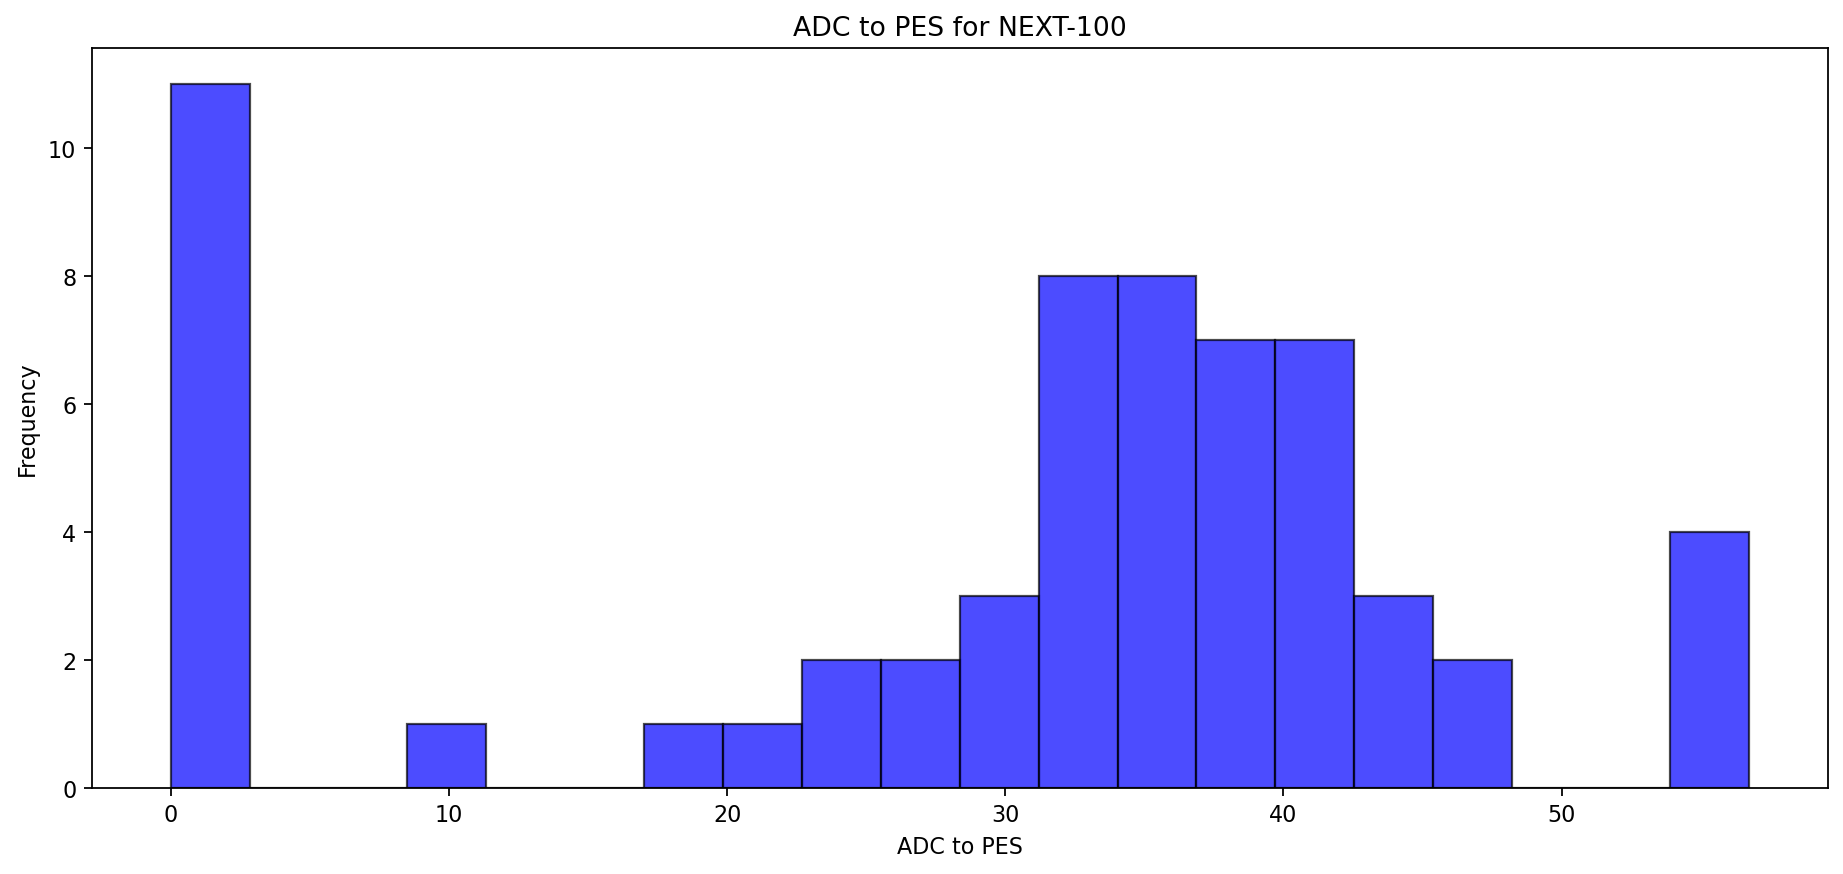

In [20]:
plot_adc_to_pes = True
if plot_adc_to_pes:
    fig, axs = plt.subplots(1, 1, figsize=(14, 6),dpi=160)
    axs.hist(adc_to_pes, bins=20, color='blue', edgecolor='black', alpha=0.7)
    axs.set_xlabel('ADC to PES')
    axs.set_ylabel('Frequency')
    axs.set_title('ADC to PES for NEXT-100')
    plt.show()

In [24]:
npmts = get_number_of_active_pmts("next100", run_number)
print(f"The data base says we have {npmts} active but 12 of them are disconnected")

The data base says we have 60 active but 12 of them are disconnected


#### PMT and SiPMs positions from DB

In [25]:
PMTPos = DataPMT('next100', 0).filter('XY')
SiPMpos = DataSiPM('next100', 0).filter('XY')
X, Y = PMTPos["X"], PMTPos["Y"]
XSi, YSi = SiPMpos["X"], SiPMpos["Y"]

#### Find data folder and file

In [26]:
folder_path, filelist, nevents_per_file = check_folder_exists(run_number, base_path, path_to_wf)
print(f"Folder path = {folder_path}, filelist = {filelist} events per file = {nevents_per_file}")


Folder path = /Users/jjgomezcadenas/NEXT/analysis//14643//hdf5/data/, filelist = ['run_14643_0010_ldc1_trg0.waveforms.h5'] events per file = 20


#### Event number

In [27]:
event_number = 5

In [28]:
filename, local_ev_number = get_filename_event(filelist, folder_path, nevents_per_file, event_number)
print(f"filename = {filename}, local event number = {local_ev_number}")

filename = /Users/jjgomezcadenas/NEXT/analysis//14643//hdf5/data/run_14643_0010_ldc1_trg0.waveforms.h5, local event number = 5


## Read waveforms

In [29]:
pmtrwf, sipmrwf, n_baseline, sp = read_waveforms(filename, local_ev_number, xbaseline=0.9)
print(f" sensorPars = {sp}, n_baseline = {n_baseline}")

 sensorPars = SensorPars(pmt_time_bins=32000, num_pmts=60, sipm_time_bins=800, num_sipms=3584), n_baseline = 28800


### Raw WaveForm to Corrected WaveForm   

#### Parameters: n_maw, thr_maw (adcs)

In [30]:
n_maw = fkr_globs["n_maw_samples"]
thr_maw =fkr_globs["thr_maw_adcs"]

print(f"n_maw = {n_maw}, thr_max = {thr_maw} adc")

deconv = deconv_pmt("next100", int(run_number), n_baseline)
cwf    = deconv(pmtrwf)

calibpmts = calibrate_pmts("next100", int(run_number), n_maw, thr_maw)
ccwfs, ccwfs_maw, cwf_sum, cwf_sum_maw   = calibpmts(cwf)

n_maw = 100, thr_max = 10 adc


In [31]:
n_baseline

28800

## SiPMs

#### Parameters: sipm_thr (pes)

In [32]:
thr_sipm = fkr_globs["thr_sipm_calib_pes"] 
print(f"thr_sipm = {thr_sipm} pes")   

sipm_rwf_to_cal  = calibrate_sipms("next100", run_number, thr_sipm)
sipmcwf = sipm_rwf_to_cal(sipmrwf)

num_sipms = sipmrwf.shape[0]
si_time =sipmrwf.shape[1]

sipm_sum = np.sum(sipmcwf, axis=0)
stdsipm = np.array([np.std(sipmcwf[i][0:300]) for i in range(num_sipms)])
qsipmx   = np.array([np.max(sipmcwf[i]) for i in range(num_sipms)])

thr_sipm = 1.0 pes


In [33]:
sipmrbwf = rebin_2d(sipmcwf, 2)

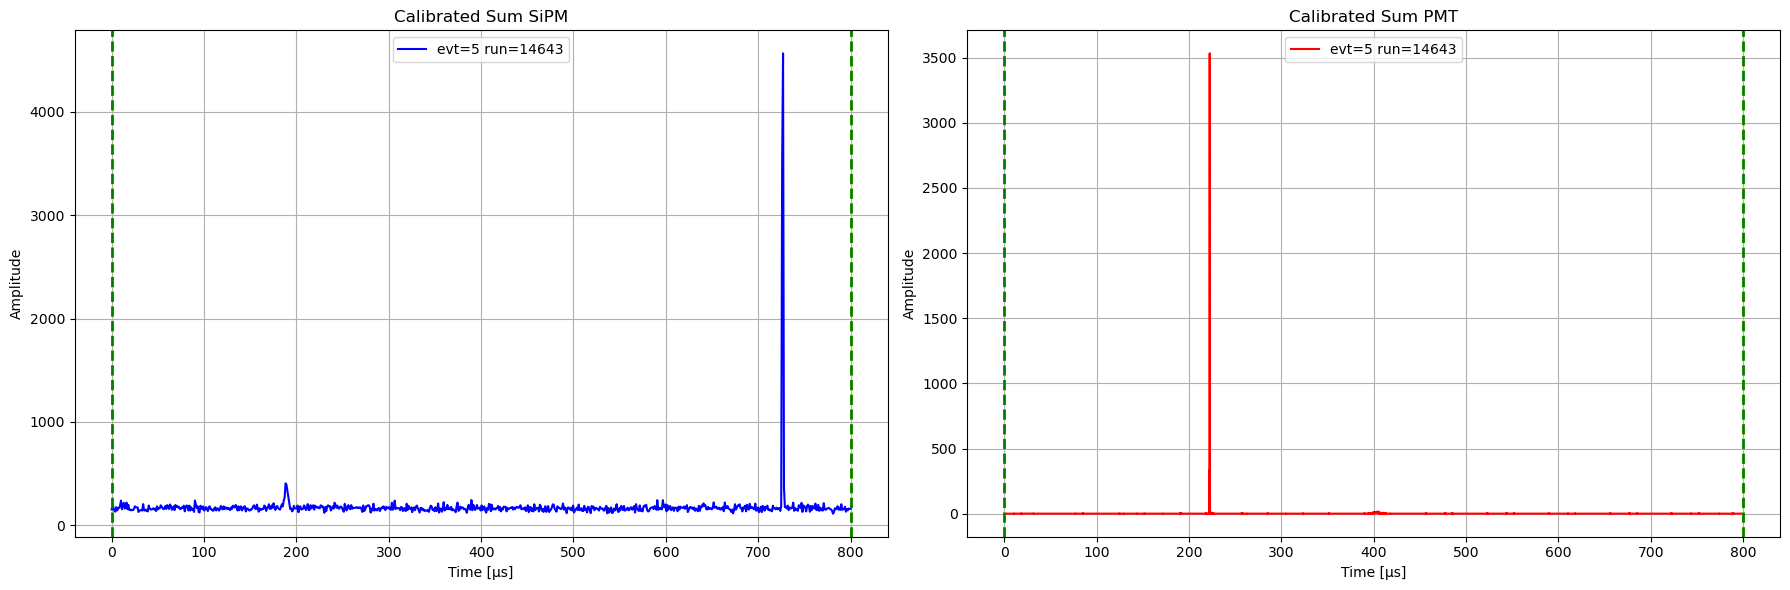

In [34]:
plot_sum_waveform(sipm_sum, cwf_sum_maw, sp.sipm_time_bins, sp.pmt_time_bins, run_number, event_number,
                  s1tmx = s1tmx/mus, s1tmn = s1tmn/mus,s2tmx = s2tmx/mus, s2tmn = s2tmn/mus,
                      figsize=(18, 6), tbin=25e-3)

## Find if there are glow spikes and suppress them

In [35]:
pp = find_peak_params(cwf_sum_maw, 0, len(cwf_sum_maw), prominence=1000, distance=20)

In [36]:
print_peak_pars(pp, tspmt)

found peaks -->[8899], time position (mus): [222.475]
prominences = [3533.37351583]
widths (mus) = [0.12964862]
left ips (mus) = [222.41079277]
right ips (mus) = [222.54044139]
left cuts = [8886], right cuts = [8911]
left cuts (mus) = [222.15], right cuts = [222.775]


left cut = 222.1514955264162, right cut = 222.79973863944807


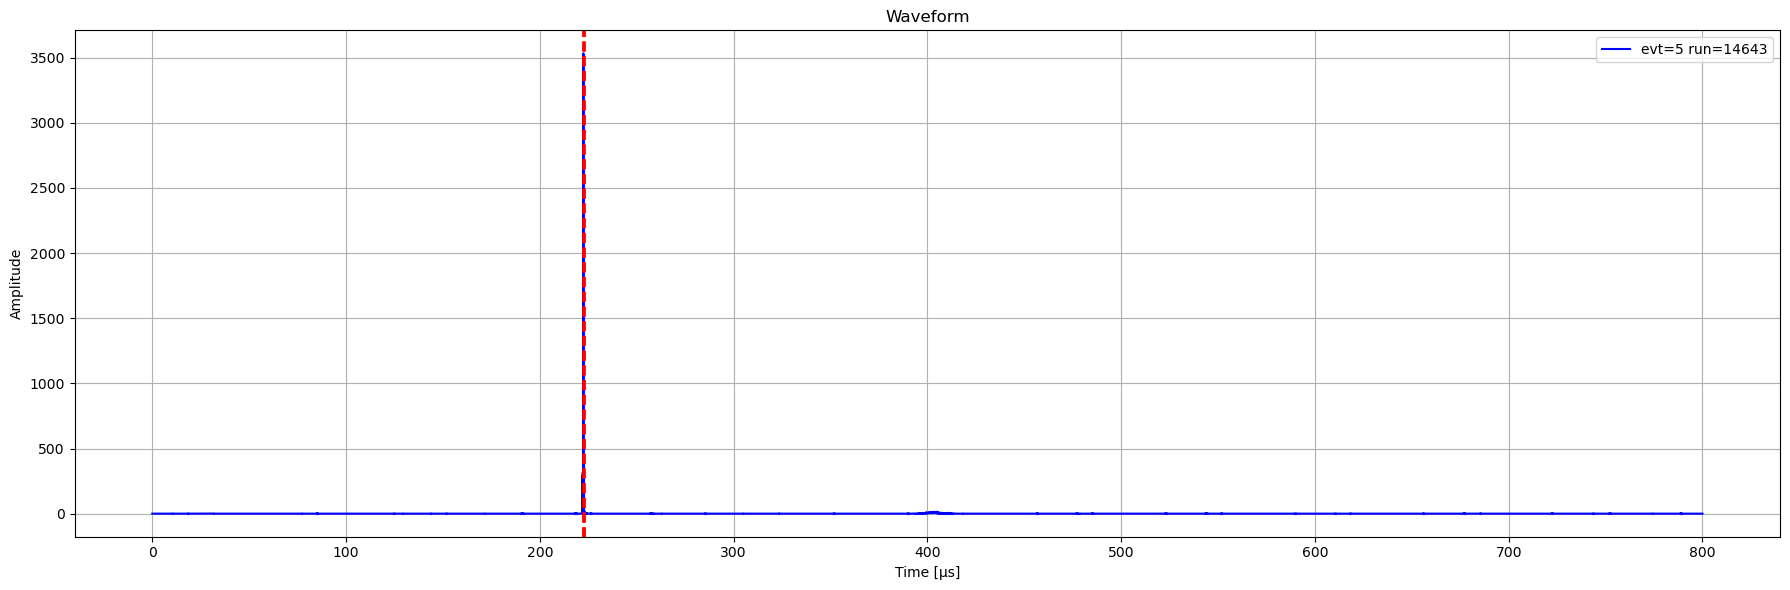

In [37]:
if len(pp.proms) > 0:
    plot_waveform(cwf_sum_maw, sp.pmt_time_bins, run_number, event_number, 
                  pp.peaks, pp.widths, pp.left_ips, pp.right_ips,
                  tbin=tspmt)

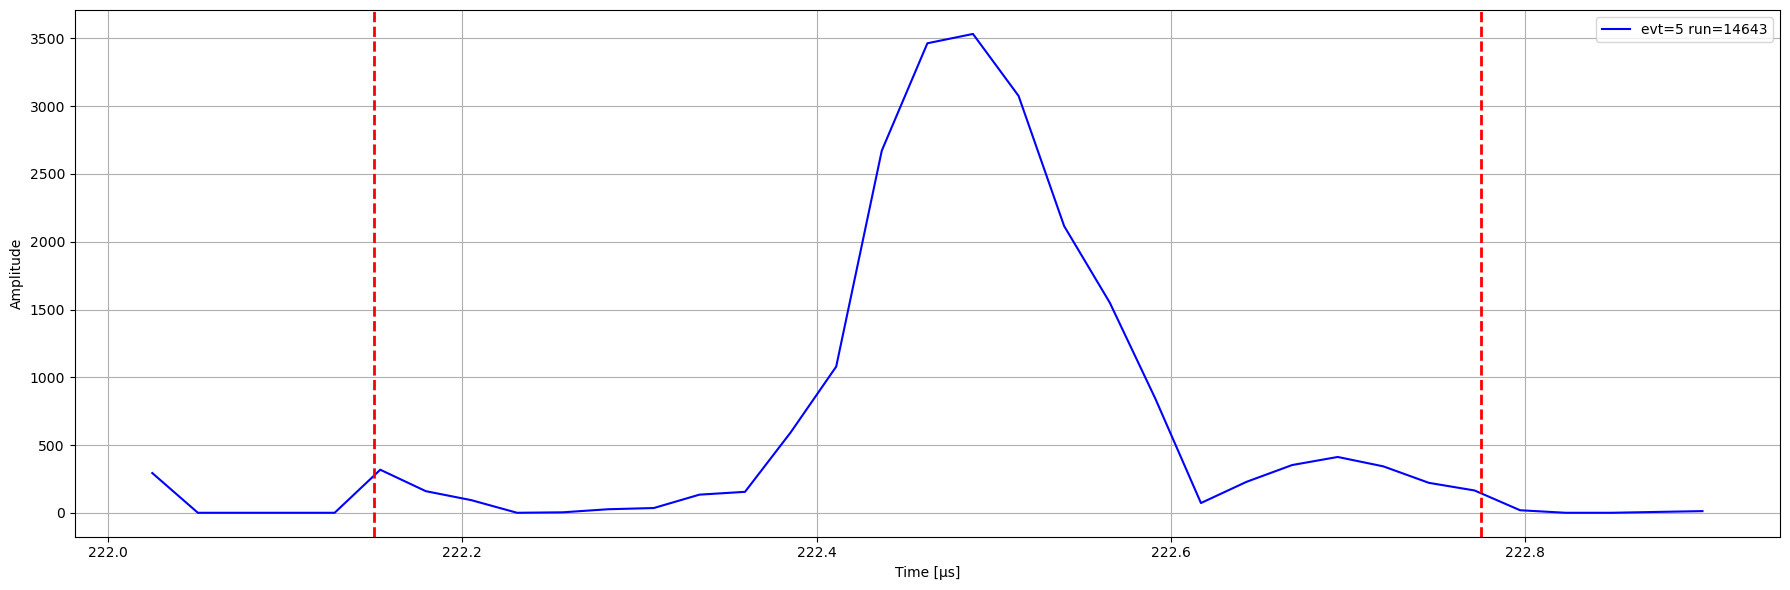

In [38]:
if len(pp.proms) > 0:
    plot_waveform_zoom_peaks(cwf_sum_maw, run_number, event_number, 
                         pp.peaks, pp.lcuts, pp.rcuts, twindows =pp.widths, 
                         tscale=True, figsize=(18, 6))

In [39]:
if len(pp.proms) > 0:
    sum_cwf_corr = suppress_glow(cwf_sum_maw, pp.peaks, pp.lcuts, pp.rcuts)
else:
    sum_cwf_corr = cwf_sum_maw

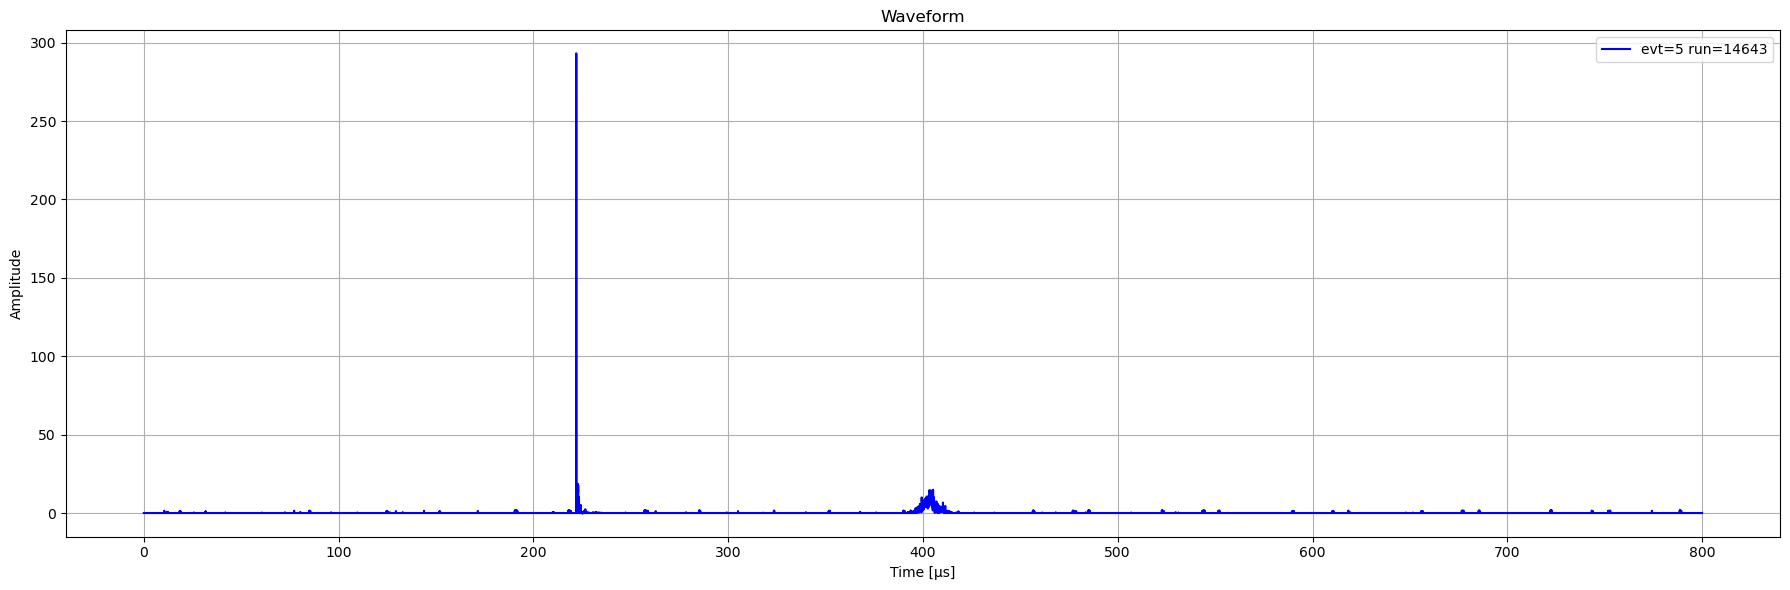

In [40]:
plot_waveform(sum_cwf_corr, sp.pmt_time_bins, run_number, event_number, figsize=(18, 6))

### S2 search

In [41]:
s2_rebin = int(parameters["s2_rebin_stride"])
cwf_s2 = rebin_sum(sum_cwf_corr, s2_rebin)
t2_rebin = cwf_s2.shape[0]
tbins2=tspmt * s2_rebin
print(f"rebined s2 bins (mus) = {tbins2}")
print(f"cwf_2 lengths = {cwf_s2.shape[0]}")

rebined s2 bins (mus) = 2.0
cwf_2 lengths = 400


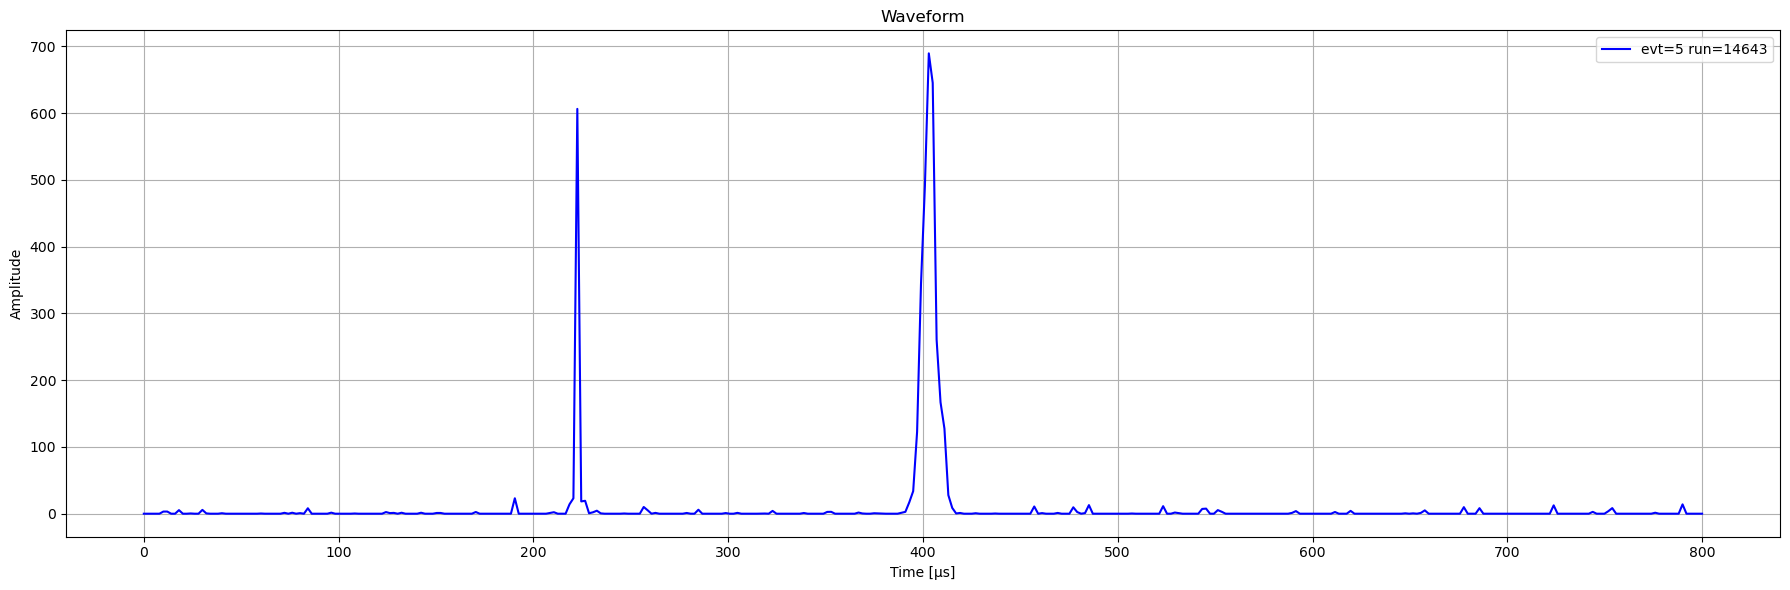

In [42]:
plot_waveform(cwf_s2, t2_rebin, run_number, event_number, figsize=(18, 6), tbin=tbins2)

In [43]:
txbin = fkr_globs["tbin_pmt_ns"]

In [44]:
cwf_s2.shape

(400,)

In [45]:
st2 = get_s2_tmin_tmax(parameters, tbin = txbin*s2_rebin)
s2tmx, s2tmn, is2tmx, is2tmn = astuple(st2)
print(f"s2tmx = {s2tmx/mus} mus, s2tmn = {s2tmn/mus} mus")
print(f"is2tmx = {is2tmx}, is2tmn = {is2tmn}")

s2tmx = 800.0 mus, s2tmn = 0.0 mus
is2tmx = 400, is2tmn = 0


In [46]:
ps2 = find_peak_params(cwf_s2, is2tmn, is2tmx, prominence=100, distance=10)

In [47]:
ps2.peaks 

array([111, 201])

In [48]:
print_peak_pars(ps2, tbins2)

found peaks -->[111 201], time position (mus): [222. 402.]
prominences = [606.19976054 689.38193184]
widths (mus) = [2.07090009 7.55257318]
left ips (mus) = [220.96039384 398.01017386]
right ips (mus) = [223.03129393 405.56274704]
left cuts = [108 191], right cuts = [113 210]
left cuts (mus) = [216. 382.], right cuts = [226. 420.]


left cut = 216.8185936484765, right cut = 227.173094117753
left cut = 382.9050275080945, right cut = 420.6678933882503


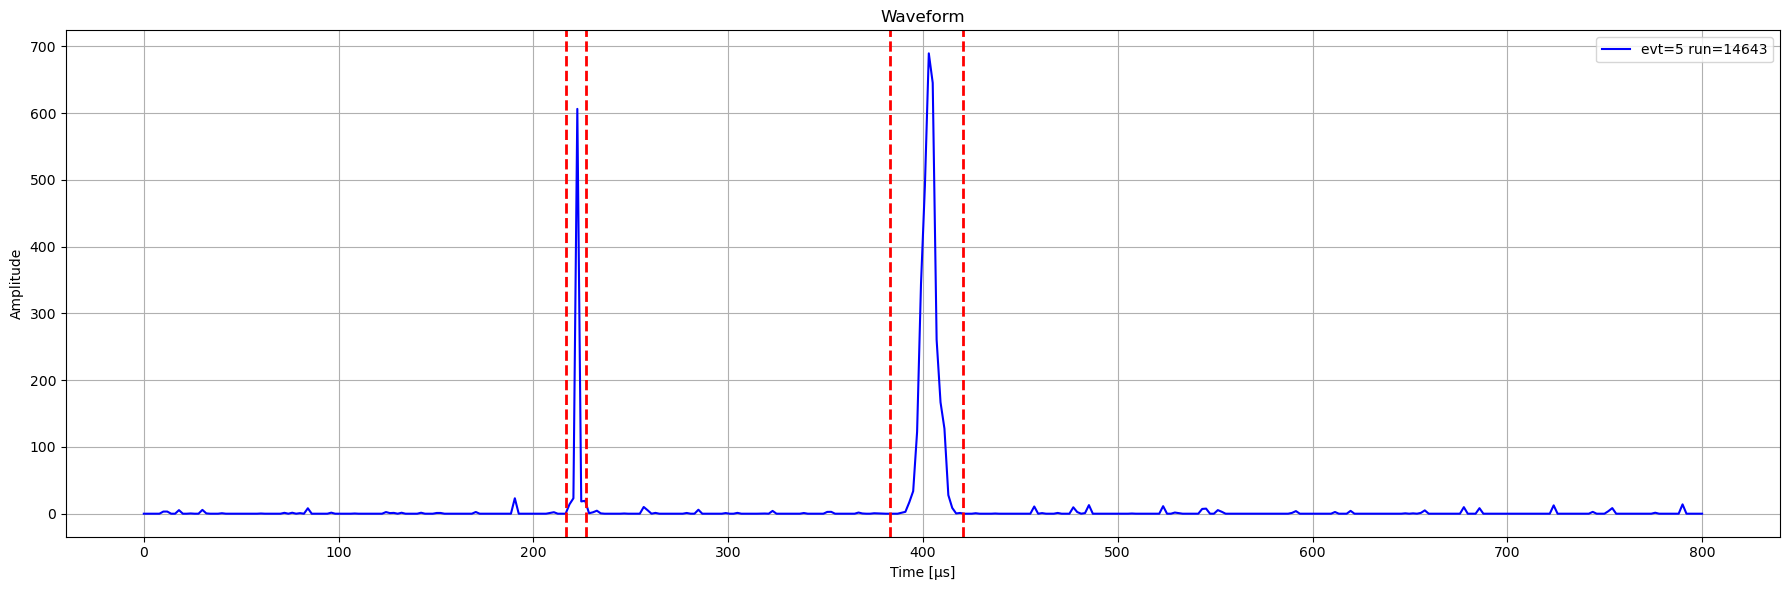

In [49]:
plot_waveform(cwf_s2, t2_rebin, run_number, event_number, 
              ps2.peaks, ps2.widths, ps2.left_ips, ps2.right_ips, tbin=tbins2, 
              figsize=(18, 6))

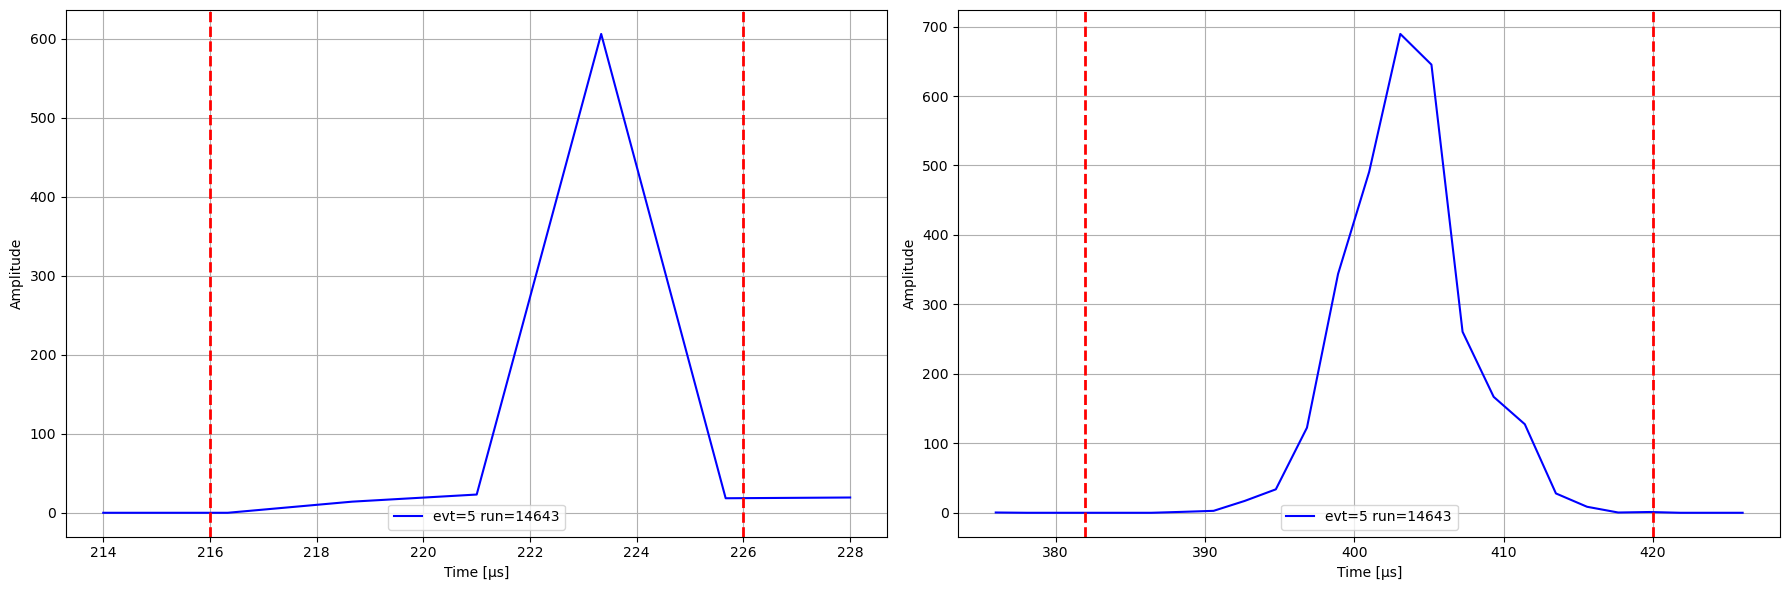

In [50]:
plot_waveform_zoom_peaks(cwf_s2, run_number, event_number, 
                         ps2.peaks, ps2.lcuts, ps2.rcuts,twindows =ps2.widths, 
                         tscale=True, tbin=tbins2, figsize=(18, 6))

In [51]:
print(f"Energy of S2 = {s12_energy(cwf_s2, ps2)} pes")

Energy of S2 = [661.7834336150814, 2940.105042112429] pes


In [52]:
ps2

PeakPars(peaks=array([111, 201]), widths=array([1.03545005, 3.77628659]), proms=array([606.19976054, 689.38193184]), left_ips=array([110.48019692, 199.00508693]), right_ips=array([111.51564697, 202.78137352]), lcuts=array([108, 191]), rcuts=array([113, 210]))

In [53]:
widths = [(ps2.rcuts[i] - ps2.lcuts[i])*tbins2 for i in range(len(ps2.rcuts))]
print(f"widths = {widths} mus")

widths = [10.0, 38.0] mus


## S1 search

In [54]:
s1_rebin = int(parameters["s1_rebin_stride"])
cwf_s1 = rebin_sum(sum_cwf_corr, s1_rebin)
t1_rebin = cwf_s1.shape[0]
tbinS1= tspmt * s1_rebin
print(f"s1 rebin = {s1_rebin}, t1 rebin = {t1_rebin}, tbin S1 = {tbinS1}")

s1 rebin = 4, t1 rebin = 8000, tbin S1 = 0.1


In [55]:
st1 = get_s1_tmin_tmax(parameters, tbin = txbin*s1_rebin)
s1tmx, s1tmn, is1tmx, is1tmn = astuple(st1)
print(f"s1tmx = {s1tmx/mus} mus, s1tmn = {s1tmn/mus} mus")
print(f"is1tmx = {is1tmx}, is1tmn = {is1tmn}")

s1tmx = 250.0 mus, s1tmn = 0.0 mus
is1tmx = 2500, is1tmn = 0


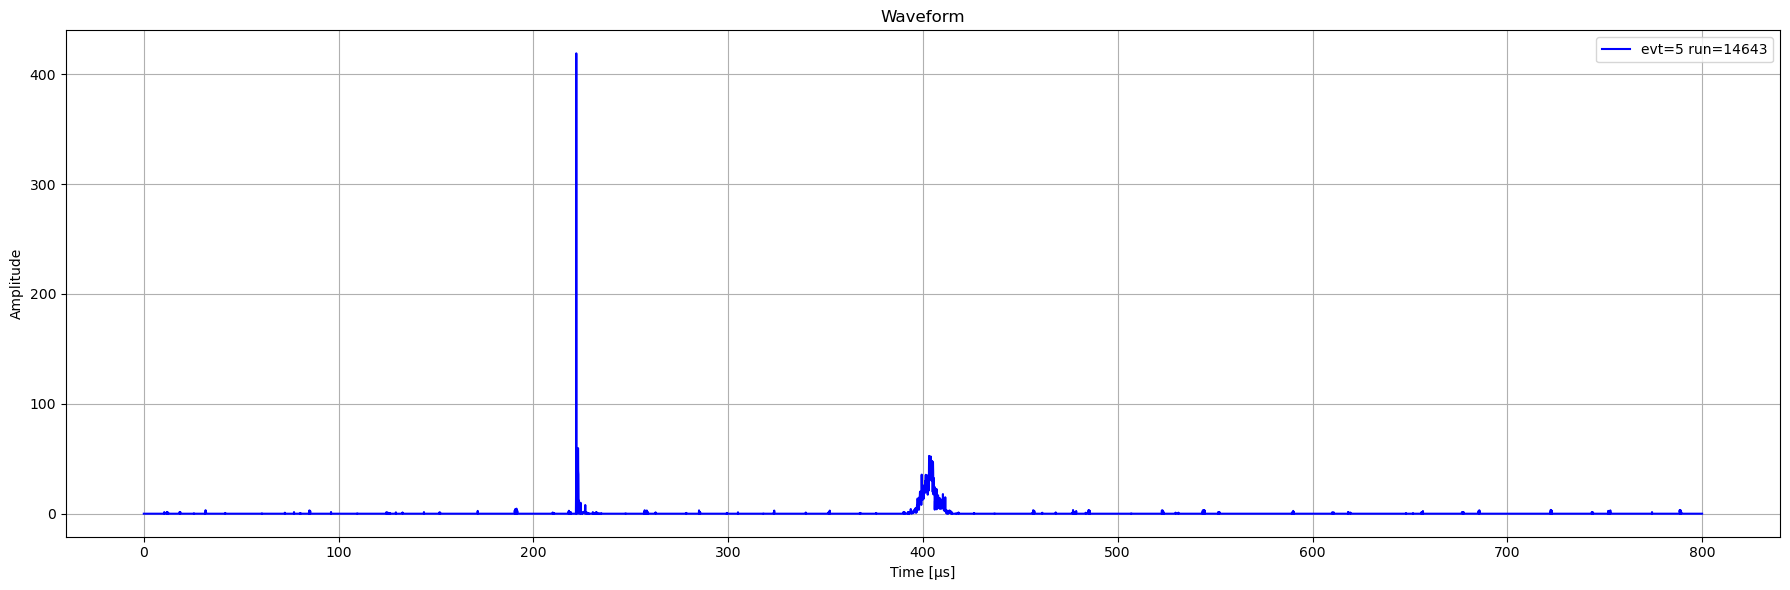

In [56]:
plot_waveform(cwf_s1, t1_rebin, run_number, event_number, figsize=(18, 6), tbin=tbinS1)

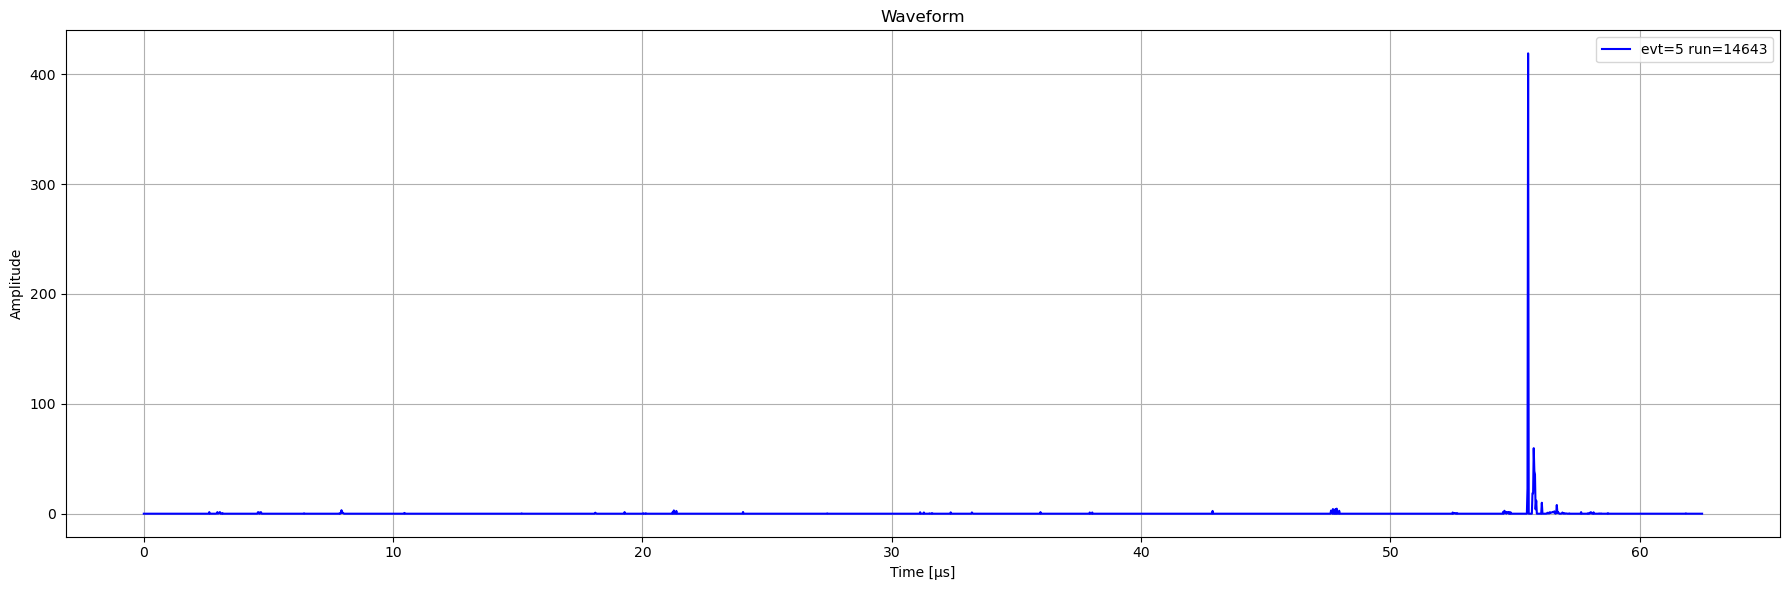

In [57]:
plot_waveform(cwf_s1[is1tmn:is1tmx], is1tmx-is1tmn, run_number, event_number, peaks=[], widths=[], left_ips=[], right_ips=[], 
                  figsize=(18, 6), tbin=25e-3)

In [58]:
ps1 = find_peak_params(cwf_s1, is1tmn, is1tmx,prominence=5, distance=10)

In [59]:
print_peak_pars(ps1, tspmt)

found peaks -->[2220 2233 2266], time position (mus): [55.5   55.825 56.65 ]
prominences = [418.92846302   7.90069053   7.91585564]
widths (mus) = [0.0257293  0.02077689 0.02706627]
left ips (mus) = [55.4867707  55.8125     56.63657762]
right ips (mus) = [55.5125     55.83327689 56.66364389]
left cuts = [2217 2230 2263], right cuts = [2222 2234 2268]
left cuts (mus) = [55.425 55.75  56.575], right cuts = [55.55 55.85 56.7 ]


left cut = 221.74124838982289, right cut = 222.25583440678474
left cut = 223.08378488395002, right cut = 223.499322674075
left cut = 226.32978029125948, right cut = 226.87110575218244


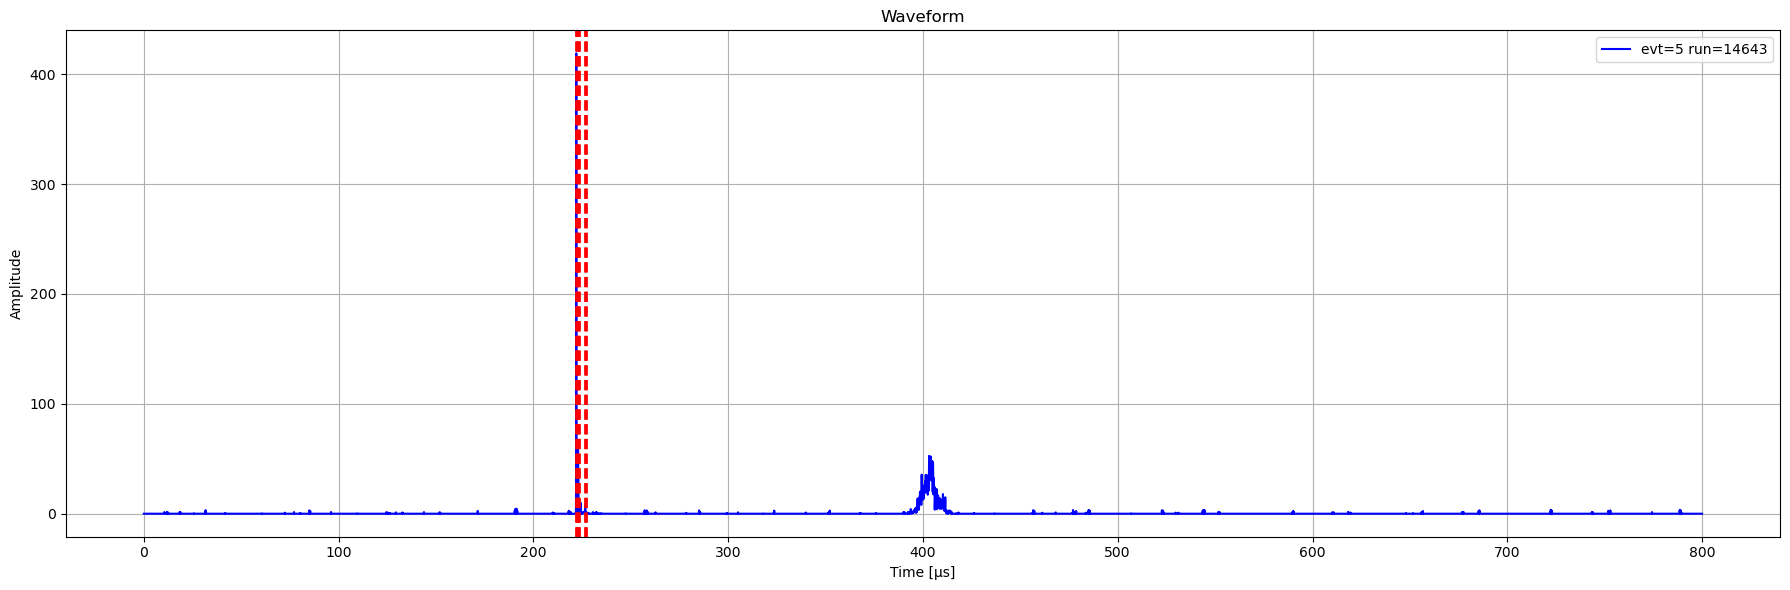

In [60]:
if len(ps1.proms) > 0:
    plot_waveform(cwf_s1, t1_rebin, run_number, event_number, 
              ps1.peaks, ps1.widths, ps1.left_ips, ps1.right_ips,  
              tbin=tbinS1, figsize=(18, 6))

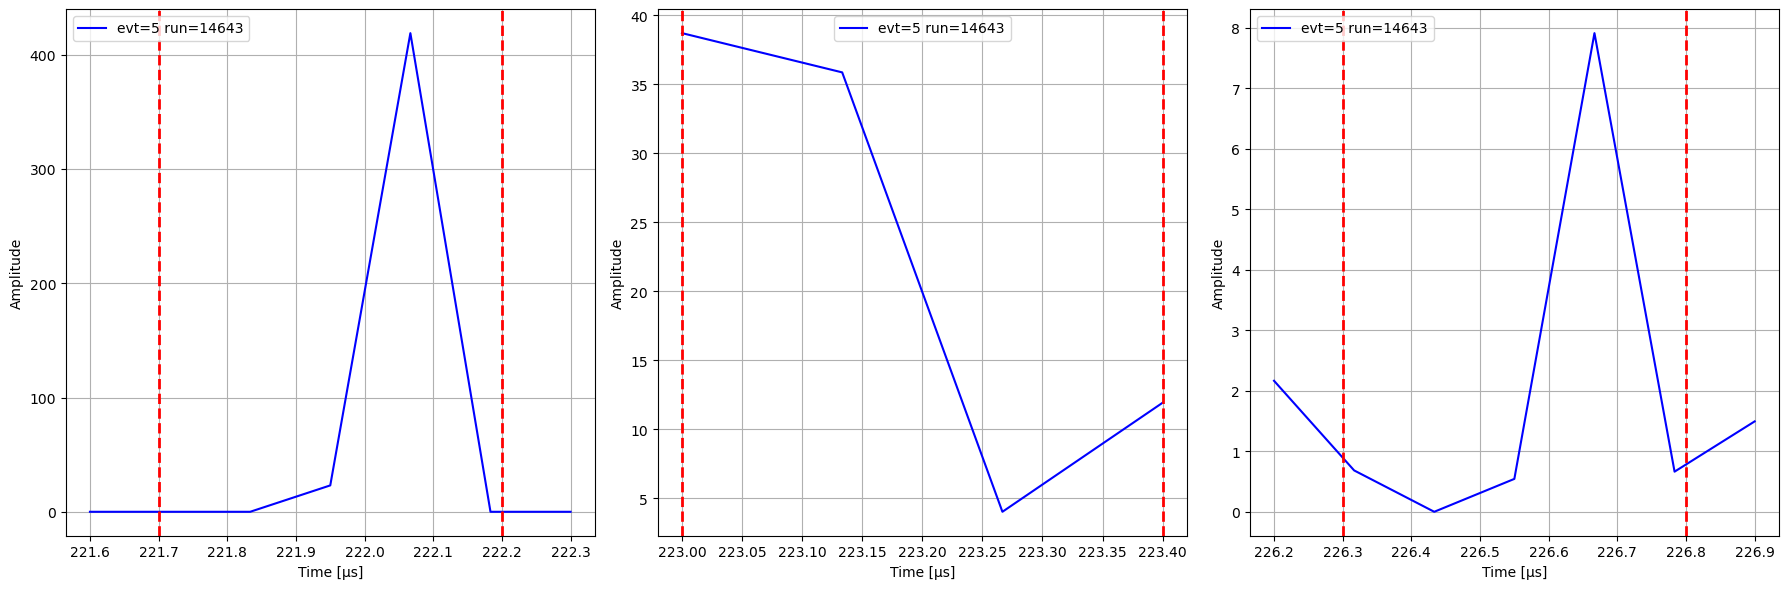

In [61]:
if len(ps1.proms) > 0:
    plot_waveform_zoom_peaks(cwf_s1, run_number, event_number, 
                         ps1.peaks, ps1.lcuts, ps1.rcuts,twindows =ps1.widths, 
                         tscale=True, tbin=tbinS1, figsize=(18, 6))

In [62]:
if len(ps1.proms) > 0:
    print(f"Energy of S1 = {s12_energy(cwf_s1, ps1)} pes")
    widths = [(ps1.rcuts[i] - ps1.lcuts[i])*tbinS1 for i in range(len(ps1.rcuts))]
    print(f"widths = {widths} mus")
else:
    print(f"S1 not found")

Energy of S1 = [442.0230231117182, 90.52832617366984, 9.807656127692974] pes
widths = [0.5, 0.4, 0.5] mus


## SiPMs

#### Masked SiPMs

In [63]:
masked_sipm

[2425]

In [65]:
#try:
msipm = masked_sipm
#except KeyError:
#    msipm=[2425]

In [77]:
sipmrbwf[msipm] = 0
qsipmx[msipm] = 0

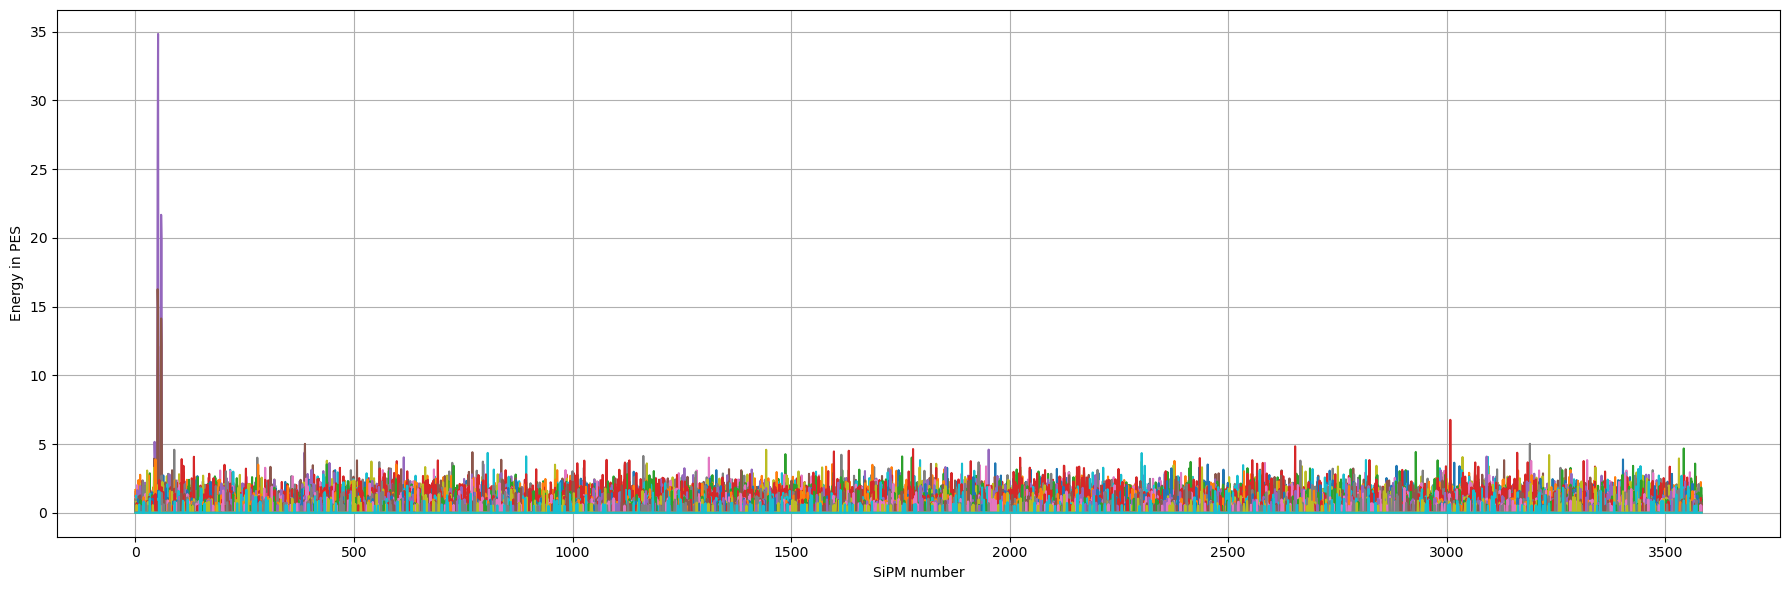

In [78]:
plot_sipmw([sipmrbwf])

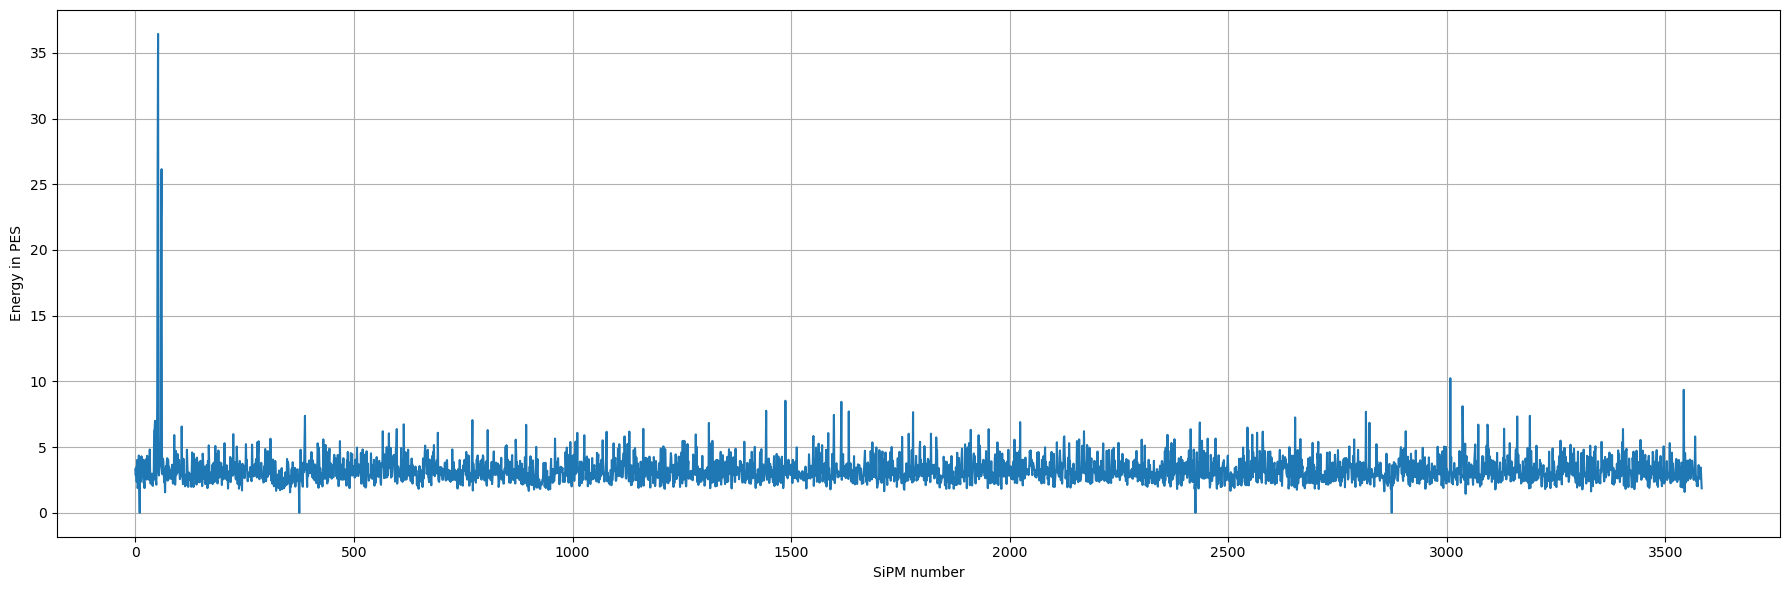

In [79]:
plot_sipmw([qsipmx])

In [80]:
max_value = np.max(qsipmx)
max_index = np.argmax(qsipmx)
print("Max value:", max_value)
print("Index of max value:", max_index)

Max value: 36.44376642088313
Index of max value: 52


In [81]:
psi = find_peak_params(qsipmx, 0, len(qsipmx), prominence=20, distance=10)

In [82]:
psi

PeakPars(peaks=array([52]), widths=array([1.98752804]), proms=array([36.44376642]), left_ips=array([50.56084293]), right_ips=array([52.54837097]), lcuts=array([46]), rcuts=array([56]))

In [83]:
psi.peaks

array([52])

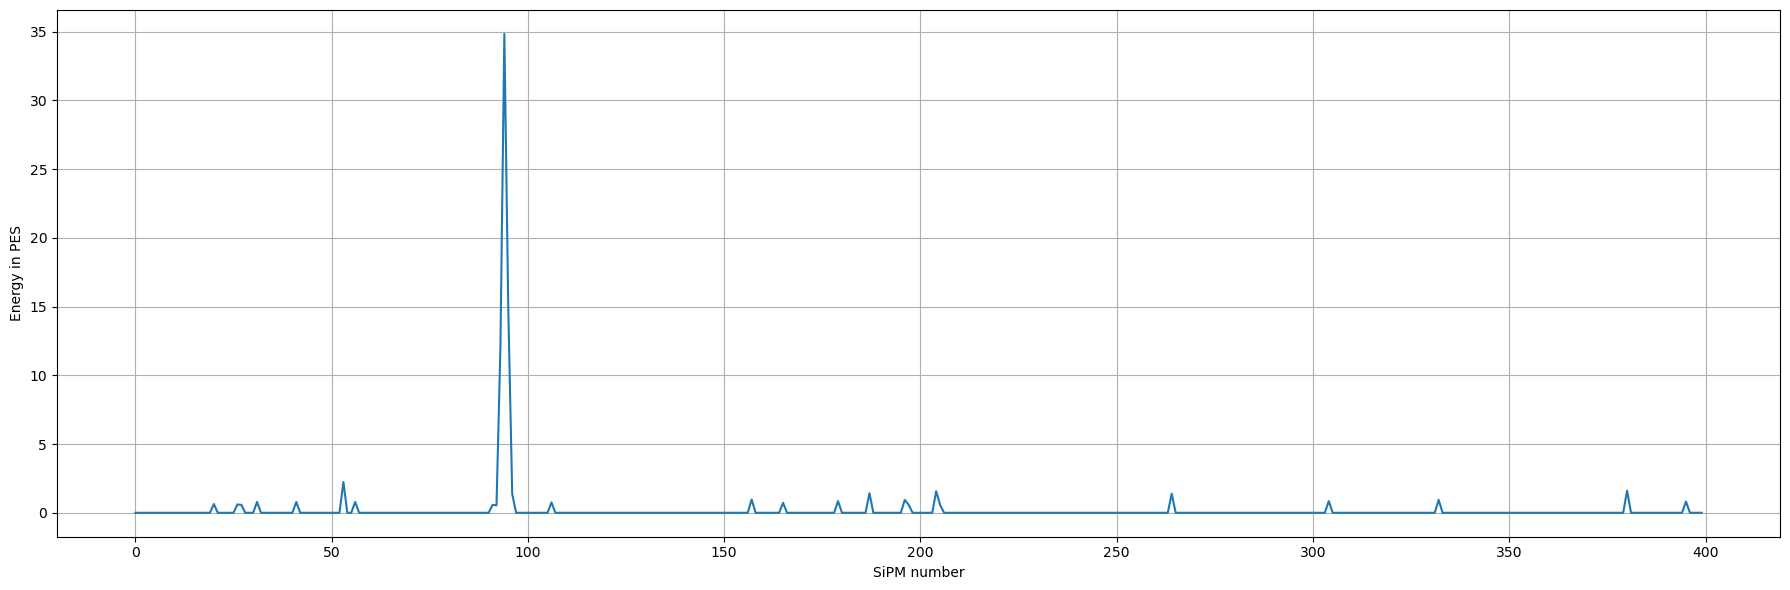

In [84]:
plot_sipmw([sipmrbwf[psi.peaks[0]]])

In [85]:
psx = find_peak_params(sipmrbwf[psi.peaks[0]], 0, 400, prominence=20, distance=10)

In [86]:
psx

PeakPars(peaks=array([94]), widths=array([1.63828128]), proms=array([34.83951424]), left_ips=array([93.23368842]), right_ips=array([94.8719697]), lcuts=array([89]), rcuts=array([98]))

In [87]:
ps2

PeakPars(peaks=array([111, 201]), widths=array([1.03545005, 3.77628659]), proms=array([606.19976054, 689.38193184]), left_ips=array([110.48019692, 199.00508693]), right_ips=array([111.51564697, 202.78137352]), lcuts=array([108, 191]), rcuts=array([113, 210]))

In [88]:
SIPMW = get_s2_windows(sipmrbwf, ps2)

[108 191] [113 210]
peak number = 0
ipl = 108, ipr=113
sipm window shape (3584, 5)
peak number = 1
ipl = 191, ipr=210
sipm window shape (3584, 19)


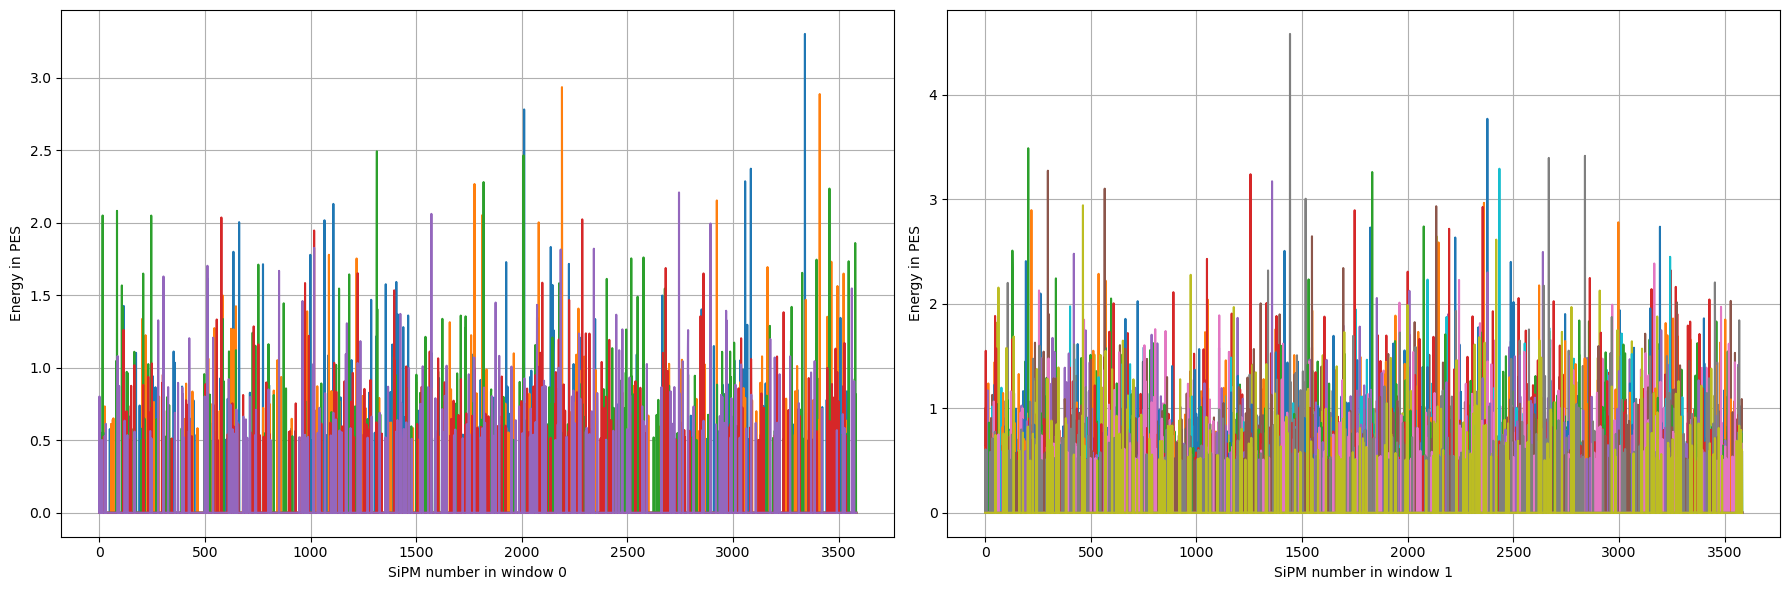

In [89]:
plot_sipmw(SIPMW)

In [90]:
QSIPM = s2_windows_sum(SIPMW, thr=5)

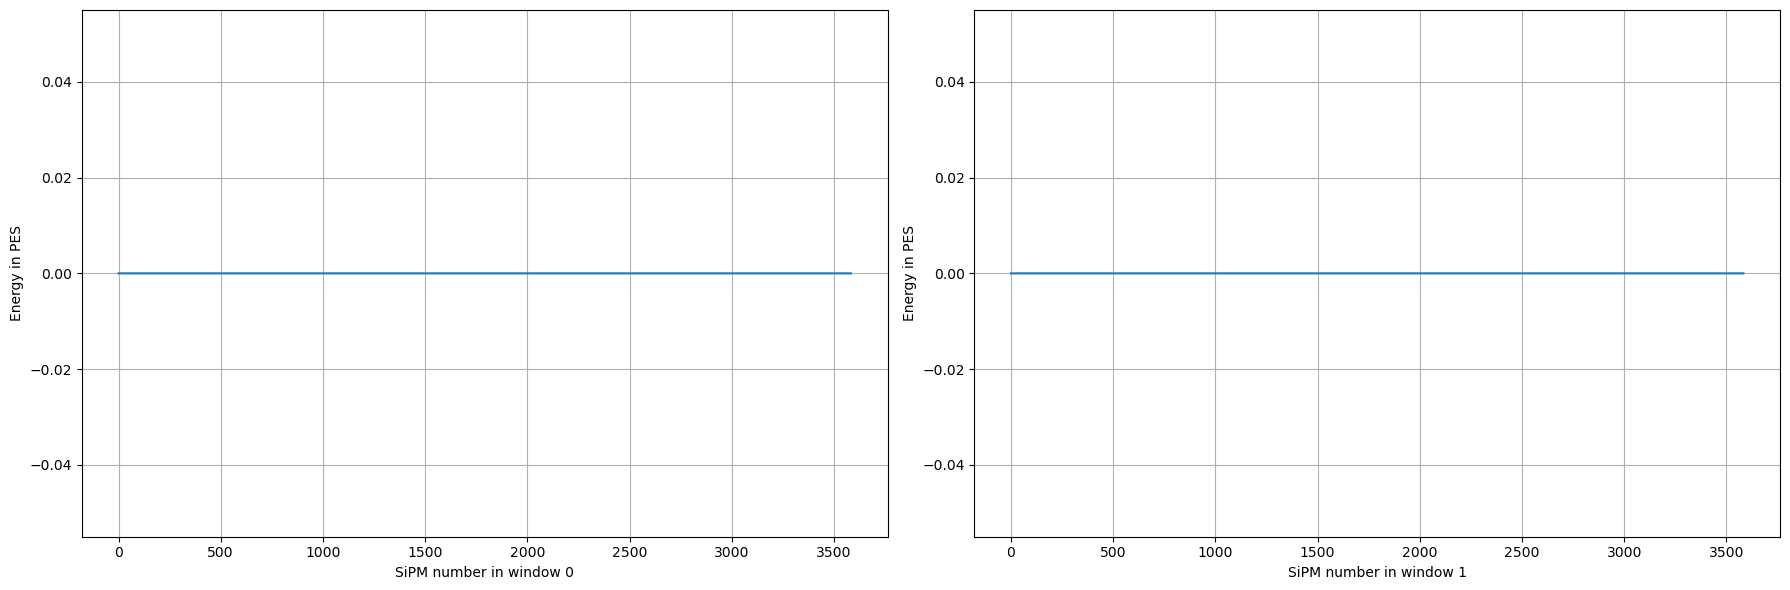

In [91]:
plot_sipmw(QSIPM)

In [ ]:
XG, YG = sipm_xg(XSi, YSi, QSIPM)

In [ ]:
QSIPM

In [ ]:
plot_sipm(XSi,YSi,QSIPM, XG, YG, figsize=(18, 6))

In [ ]:
def get_sipm_above_thr(QSIPM, thr):
    for i, qsipm in enumerate(QSIPM):
        # Get boolean mask of values > 0
        mask = qsipm > thr

        # Get the indices of these nonzero values
        indices = np.where(mask)[0]  

        # Get the nonzero values themselves
        values = qsipm[nonzero_indices]

        # Print them
        print(f"Sipm: Window = {i}")
        for idx, val in zip(indices, values):
            print(f"sipm>0: i = {idx}, Value: {val}")

In [ ]:
MX = get_sipm_max(QSIPM)

In [ ]:
MX